In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import SGDClassifier
from collections import Counter
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix,precision_recall_fscore_support

In [2]:
df=pd.read_csv('ks-projects-201801.csv',encoding= 'latin_1')
df.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


In [3]:
df.columns

Index(['ID', 'name', 'category', 'main_category', 'currency', 'deadline',
       'goal', 'launched', 'pledged', 'state', 'backers', 'country',
       'usd pledged', 'usd_pledged_real', 'usd_goal_real'],
      dtype='object')

今回の方針  
#### nameは~~扱いが難しいので削除~~
### 文字数にするといいというアドバイスがあったので文字数or単語数でデータ化する
categoryは数が多すぎる、分類が細かすぎるので削除、使用しない
#### main_categoryは~~種類毎に数字化する~~
### onehotで分類する
#### currencyはcountryと相関が高そうだがとりあえず~~数字化する~~
### onehotで分類する
deadlineはとりあえず数字化するけど、本来は月とかだけでもいいかもしれない  
goalは使用しない、目標額にはusd_goal_realを使用する  
#### launchedは開始時刻、~~これは推定をするときにはわからないデータとして判断すると削除する方針~~ 
### こういったプロジェクトは任意に開始時刻が決定できるらしいので使用するにする
pledgedは到達金額、つまり結果の事なので、今回の分類には使用しない  
stateは目的変数として使用する  
backersは支援者の数、これも結果なので、今回は使用しない  
countryは数字化するが、アメリカが多すぎるのでどう対応するかは迷う  
usd pledgedは結果なので使用しない。  
usd_goal_realは使用する。

### 目的変数

failed        197719
successful    133956
canceled       38779
undefined       3562
live            2799
suspended       1846
Name: state, dtype: int64


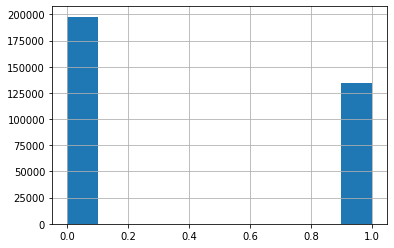

In [4]:
print(df['state'].value_counts())
dft=df.copy()
dft.drop(dft.index[dft.state == 'canceled'],inplace=True)
dft.drop(dft.index[dft.state == 'undefined'],inplace=True)
dft.drop(dft.index[dft.state == 'live'],inplace=True)
dft.drop(dft.index[dft.state == 'suspended'],inplace=True)
dft['state']=dft['state'].replace('failed',0)
dft['state']=dft['state'].replace('successful',1)
dft=dft.reset_index(drop=True)
dft['state'].hist(bins=10)

### 使わないデータの削除

In [5]:
dft=dft.drop(['ID','category','usd pledged','goal','pledged','backers','usd_pledged_real'],axis=1)
dft.head()

,name,main_category,currency,deadline,launched,state,country,usd_goal_real
0,The Songs of Adelaide & Abullah,Publishing,GBP,2015-10-09,2015-08-11 12:12:28,0,GB,1533.95
1,Greeting From Earth: ZGAC Arts Capsule For ET,Film & Video,USD,2017-11-01,2017-09-02 04:43:57,0,US,30000.00
2,Where is Hank?,Film & Video,USD,2013-02-26,2013-01-12 00:20:50,0,US,45000.00
3,ToshiCapital Rekordz Needs Help to Complete Album,Music,USD,2012-04-16,2012-03-17 03:24:11,0,US,5000.00
4,Monarch Espresso Bar,Food,USD,2016-04-01,2016-02-26 13:38:27,1,US,50000.00


In [6]:
dft=dft.loc[:,['state','main_category', 'currency','country','usd_goal_real', 'name','deadline','launched']]
dft.head()

,state,main_category,currency,country,usd_goal_real,name,deadline,launched
0,0,Publishing,GBP,GB,1533.95,The Songs of Adelaide & Abullah,2015-10-09,2015-08-11 12:12:28
1,0,Film & Video,USD,US,30000.00,Greeting From Earth: ZGAC Arts Capsule For ET,2017-11-01,2017-09-02 04:43:57
2,0,Film & Video,USD,US,45000.00,Where is Hank?,2013-02-26,2013-01-12 00:20:50
3,0,Music,USD,US,5000.00,ToshiCapital Rekordz Needs Help to Complete Album,2012-04-16,2012-03-17 03:24:11
4,1,Food,USD,US,50000.00,Monarch Espresso Bar,2016-04-01,2016-02-26 13:38:27


### 欠損値の確認と除去

In [7]:
dft.isnull().sum()

state            0
main_category    0
currency         0
country          0
usd_goal_real    0
name             3
deadline         0
launched         0
dtype: int64

In [8]:
dft=dft.dropna()
dft.isnull().sum()

state            0
main_category    0
currency         0
country          0
usd_goal_real    0
name             0
deadline         0
launched         0
dtype: int64

### nameを文字数化する

In [9]:
dft['words'] = dft['name'].apply(lambda x: len(Counter(str(x).split())))

### 期間、終了月、終了日は投資側の都合が絡んでくると思われるので説明変数化する

In [10]:
dft['deadmonth'] = pd.to_datetime(dft['deadline']).dt.month
dft['deadday'] = pd.to_datetime(dft['deadline']).dt.day

In [11]:
dft['period'] = (pd.to_datetime(dft['deadline']) - pd.to_datetime(dft['launched'])).dt.days

In [12]:
# pd.plotting.scatter_matrix(dft, figsize=(10,10))
# plt.show()

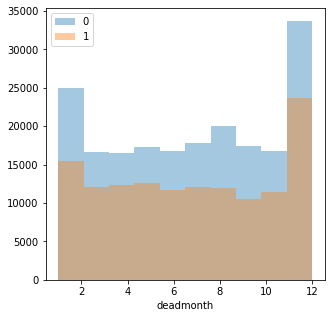

In [13]:
plt.figure(figsize=(5,5))
sns.distplot(dft[dft['state']==0]['deadmonth'],kde=False,rug=False,bins=10,label='0')
sns.distplot(dft[dft['state']==1]['deadmonth'],kde=False,rug=False,bins=10,label='1')
plt.legend()
plt.show()

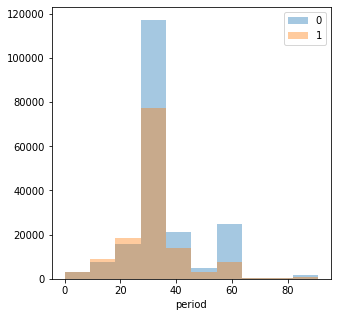

In [14]:
plt.figure(figsize=(5,5))
sns.distplot(dft[dft['state']==0]['period'],kde=False,rug=False,bins=10,label='0')
sns.distplot(dft[dft['state']==1]['period'],kde=False,rug=False,bins=10,label='1')
plt.legend()
plt.show()

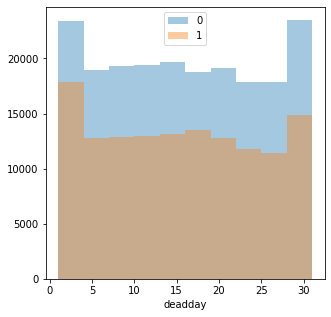

In [15]:
plt.figure(figsize=(5,5))
sns.distplot(dft[dft['state']==0]['deadday'],kde=False,rug=False,bins=10,label='0')
sns.distplot(dft[dft['state']==1]['deadday'],kde=False,rug=False,bins=10,label='1')
plt.legend()
plt.show()

In [16]:
dft

,state,main_category,currency,country,usd_goal_real,name,deadline,launched,words,deadmonth,deadday,period
0,0,Publishing,GBP,GB,1533.95,The Songs of Adelaide & Abullah,2015-10-09,2015-08-11 12:12:28,6,10,9,58
1,0,Film & Video,USD,US,30000.00,Greeting From Earth: ZGAC Arts Capsule For ET,2017-11-01,2017-09-02 04:43:57,8,11,1,59
2,0,Film & Video,USD,US,45000.00,Where is Hank?,2013-02-26,2013-01-12 00:20:50,3,2,26,44
3,0,Music,USD,US,5000.00,ToshiCapital Rekordz Needs Help to Complete Album,2012-04-16,2012-03-17 03:24:11,7,4,16,29
4,1,Food,USD,US,50000.00,Monarch Espresso Bar,2016-04-01,2016-02-26 13:38:27,3,4,1,34
...,...,...,...,...,...,...,...,...,...,...,...,...
331670,0,Food,USD,US,6500.00,"Homemade fresh dog food, Cleveland OH",2017-04-19,2017-03-20 22:08:22,6,4,19,29
331671,0,Film & Video,USD,US,1500.00,The Tribe,2011-07-19,2011-06-22 03:35:14,2,7,19,26
331672,0,Film & Video,USD,US,15000.00,Walls of Remedy- New lesbian Romantic Comedy f...,2010-08-16,2010-07-01 19:40:30,11,8,16,45
331673,0,Technology,USD,US,15000.00,BioDefense Education Kit,2016-02-13,2016-01-13 18:13:53,3,2,13,30


### dataframe 整理

In [17]:
dft['country']=dft['country'].replace('US',1)
mask = dft.country != 1
dft.loc[mask,'country']=0

In [18]:
dft=dft.drop(['name'],axis=1)
dft.head()

,state,main_category,currency,country,usd_goal_real,deadline,launched,words,deadmonth,deadday,period
0,0,Publishing,GBP,0,1533.95,2015-10-09,2015-08-11 12:12:28,6,10,9,58
1,0,Film & Video,USD,1,30000.00,2017-11-01,2017-09-02 04:43:57,8,11,1,59
2,0,Film & Video,USD,1,45000.00,2013-02-26,2013-01-12 00:20:50,3,2,26,44
3,0,Music,USD,1,5000.00,2012-04-16,2012-03-17 03:24:11,7,4,16,29
4,1,Food,USD,1,50000.00,2016-04-01,2016-02-26 13:38:27,3,4,1,34


In [19]:
dft=dft.drop(['deadline','launched'],axis=1)
dft.head()


,state,main_category,currency,country,usd_goal_real,words,deadmonth,deadday,period
0,0,Publishing,GBP,0,1533.95,6,10,9,58
1,0,Film & Video,USD,1,30000.00,8,11,1,59
2,0,Film & Video,USD,1,45000.00,3,2,26,44
3,0,Music,USD,1,5000.00,7,4,16,29
4,1,Food,USD,1,50000.00,3,4,1,34


### filter法による特徴量選択

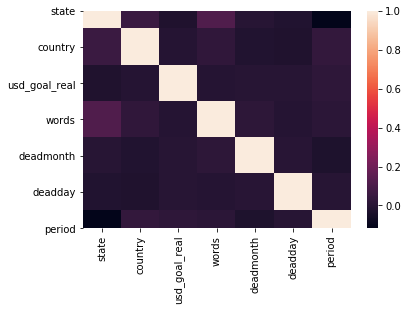

In [20]:
sns.heatmap(dft[["state", "country", "usd_goal_real", "words", "deadmonth","deadday","period"]].corr())
plt.show()

In [21]:
(dft[["state", "country", "usd_goal_real", "words", "deadmonth","deadday","period"]].corr())

,state,country,usd_goal_real,words,deadmonth,deadday,period
state,1.000000,0.056249,-0.023735,0.116565,-0.001871,-0.019835,-0.116438
country,0.056249,1.000000,-0.003757,0.027392,-0.020304,-0.022570,0.035190
usd_goal_real,-0.023735,-0.003757,1.000000,-0.007119,0.000993,-0.000948,0.021606
words,0.116565,0.027392,-0.007119,1.000000,0.016498,-0.004535,0.010962
deadmonth,-0.001871,-0.020304,0.000993,0.016498,1.000000,0.004475,-0.025955
deadday,-0.019835,-0.022570,-0.000948,-0.004535,0.004475,1.000000,-0.000095
period,-0.116438,0.035190,0.021606,0.010962,-0.025955,-0.000095,1.000000


In [22]:
(dft[["country", "usd_goal_real", "words", "deadmonth","deadday","period"]].corr())

,country,usd_goal_real,words,deadmonth,deadday,period
country,1.000000,-0.003757,0.027392,-0.020304,-0.022570,0.035190
usd_goal_real,-0.003757,1.000000,-0.007119,0.000993,-0.000948,0.021606
words,0.027392,-0.007119,1.000000,0.016498,-0.004535,0.010962
deadmonth,-0.020304,0.000993,0.016498,1.000000,0.004475,-0.025955
deadday,-0.022570,-0.000948,-0.004535,0.004475,1.000000,-0.000095
period,0.035190,0.021606,0.010962,-0.025955,-0.000095,1.000000


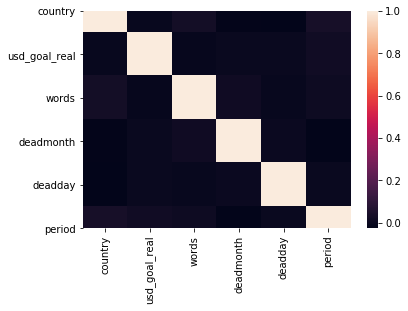

In [23]:
sns.heatmap(dft[[ "country", "usd_goal_real", "words", "deadmonth","deadday","period"]].corr())
plt.show()

- 相関関係は低いので特徴量を削除しない

### ダミー変数化

In [24]:
dft = pd.get_dummies(dft,columns={'main_category'})
dft.head()

,state,currency,country,usd_goal_real,words,deadmonth,deadday,period,main_category_Art,main_category_Comics,...,main_category_Fashion,main_category_Film & Video,main_category_Food,main_category_Games,main_category_Journalism,main_category_Music,main_category_Photography,main_category_Publishing,main_category_Technology,main_category_Theater
0,0,GBP,0,1533.95,6,10,9,58,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,USD,1,30000.00,8,11,1,59,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,USD,1,45000.00,3,2,26,44,0,0,...,0,1,0,0,0,0,0,0,0,0
3,0,USD,1,5000.00,7,4,16,29,0,0,...,0,0,0,0,0,1,0,0,0,0
4,1,USD,1,50000.00,3,4,1,34,0,0,...,0,0,1,0,0,0,0,0,0,0


In [25]:
dft = pd.get_dummies(dft,columns={'currency'})
dft.head()

,state,country,usd_goal_real,words,deadmonth,deadday,period,main_category_Art,main_category_Comics,main_category_Crafts,...,currency_EUR,currency_GBP,currency_HKD,currency_JPY,currency_MXN,currency_NOK,currency_NZD,currency_SEK,currency_SGD,currency_USD
0,0,0,1533.95,6,10,9,58,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0,1,30000.00,8,11,1,59,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,1,45000.00,3,2,26,44,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,1,5000.00,7,4,16,29,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,1,1,50000.00,3,4,1,34,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [26]:
# ばらつき圧縮　対数の方がいいかも
dft.usd_goal_real = np.power(dft.usd_goal_real,1/2/2/2)
dft.period = np.power(dft.period,0.25)

In [27]:
dft.describe()

,state,country,usd_goal_real,words,deadmonth,deadday,period,main_category_Art,main_category_Comics,main_category_Crafts,...,currency_EUR,currency_GBP,currency_HKD,currency_JPY,currency_MXN,currency_NOK,currency_NZD,currency_SEK,currency_SGD,currency_USD
count,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,...,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000
mean,0.403881,0.788001,2.987160,5.566804,6.758499,15.271491,2.363057,0.077305,0.029782,0.023571,...,0.043350,0.088868,0.001438,0.000069,0.004254,0.001761,0.003841,0.004553,0.001369,0.788457
std,0.490675,0.408724,0.632456,2.689037,3.315179,9.038861,0.232945,0.267076,0.169987,0.151710,...,0.203644,0.284553,0.037896,0.008327,0.065085,0.041925,0.061858,0.067320,0.036972,0.408403
min,0.000000,0.000000,0.562341,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,2.586001,3.000000,4.000000,7.000000,2.320596,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,1.000000,2.899821,5.000000,7.000000,15.000000,2.320596,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,1.000000,3.326683,8.000000,10.000000,23.000000,2.432299,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,10.656917,20.000000,12.000000,31.000000,3.088591,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Day2 result：SVM
- 正答率(訓練性能)：68.061%
- 正答率(汎化性能)：65.635%

### Day1 result：ロジスティック回帰
- 正答率(訓練性能)：61.695%

## Day3 start

In [30]:
%matplotlib inline
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from common_func import plot_decision_regions
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

In [46]:
y=dft.state.values
X=dft.iloc[:,1:].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=1234)


In [38]:
# dft[["usd_goal_real", "words", "deadmonth","deadday","period"]]

sc=StandardScaler()
X_train[1:6] = sc.fit_transform(X_train[1:6])
X_test[1:6] = sc.transform(X_test[1:6])

clf= SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3)
clf.fit(X_train, y_train)
y_est = clf.predict(X_train)
print('訓練性能')
print('対数尤度 = {:.3f}'.format(- log_loss(y_train, y_est)))
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y_train, y_est)))
conf_mat = pd.DataFrame(confusion_matrix(y_train, y_est), 
                        index=['正解 = 成功しない', '正解 = 成功する'], 
                        columns=['予測 = 成功しない', '予測 = 成功する'])
conf_mat

訓練性能
対数尤度 = -11.965
正答率 = 65.357%


,予測 = 成功しない,予測 = 成功する
正解 = 成功しない,118823,29515
正解 = 成功する,56660,43756


In [39]:
# 汎化性能
y_est_h = clf.predict(X_test)

print('*** 汎化性能 ***')
print('対数尤度 = {:.3f}'.format(- log_loss(y_test, y_est_h)))
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y_test, y_est_h)))
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_est_h), 
                        index=['正解 = 成功しない', '正解 = 成功する'], 
                        columns=['予測 = 成功しない', '予測 = 成功する'])
conf_mat

*** 汎化性能 ***
対数尤度 = -11.987
正答率 = 65.295%


,予測 = 成功しない,予測 = 成功する
正解 = 成功しない,39474,9904
正解 = 成功する,18873,14667


### ラッパー法を試してみる

In [41]:
from sklearn.feature_selection import RFECV

estimator=clf= SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3)
rfecv = RFECV(estimator, cv=10, scoring='accuracy')
rfecv.fit(X_train, y_train)

RFECV(cv=10,
   estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=10000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='none',
       power_t=0.5, random_state=1234, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False),
   min_features_to_select=1, n_jobs=None, scoring='accuracy', step=1,
   verbose=0)

Feature ranking: 
[1 1 1 1 4 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1 5 1 2 1 1 1 1]


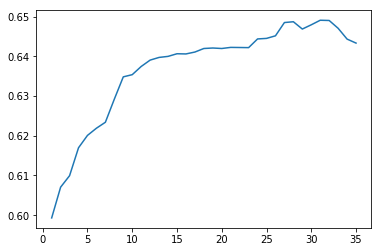

In [42]:
print('Feature ranking: \n{}'.format(rfecv.ranking_))
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [43]:
print(rfecv.support_)
remove_idx = ~rfecv.support_
remove_idx

[ True  True  True  True False  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True False  True  True False  True False  True  True  True  True]


array([False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False,  True, False,  True, False, False, False, False])

In [52]:
dfx=dft.iloc[:,1:]
remove_feature = dfx.columns[remove_idx]
remove_feature

Index(['deadday', 'currency_EUR', 'currency_JPY', 'currency_NOK'], dtype='object')

In [53]:
dft_s = dft.drop(remove_feature,axis=1)

In [54]:
dft_s.head()

,state,country,usd_goal_real,words,deadmonth,period,main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,...,currency_CAD,currency_CHF,currency_DKK,currency_GBP,currency_HKD,currency_MXN,currency_NZD,currency_SEK,currency_SGD,currency_USD
0,0,0,2.501649,6,10,2.759669,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,1,3.627773,8,11,2.771488,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,1,3.816380,3,2,2.575510,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,1,2.899821,7,4,2.320596,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,1,1,3.866974,3,4,2.414736,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [55]:
y=dft.state.values
X=dft.iloc[:,1:].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=1234)
sc=StandardScaler()
X_train[1:5] = sc.fit_transform(X_train[1:5])
X_test[1:5] = sc.transform(X_test[1:5])

In [57]:
clf.fit(X_train, y_train)
y_est = clf.predict(X_train)
print('訓練性能')
print('対数尤度 = {:.3f}'.format(- log_loss(y_train, y_est)))
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y_train, y_est)))
conf_mat = pd.DataFrame(confusion_matrix(y_train, y_est), 
                        index=['正解 = 成功しない', '正解 = 成功する'], 
                        columns=['予測 = 成功しない', '予測 = 成功する'])
conf_mat

訓練性能
対数尤度 = -11.965
正答率 = 65.358%


,予測 = 成功しない,予測 = 成功する
正解 = 成功しない,118824,29514
正解 = 成功する,56659,43757


#### ステップワイズの結果、ロジスティック回帰ではほとんど変わらなかった　+0.001%

## 決定木

In [65]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
y=dft.state.values
X=dft.iloc[:,1:].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=1234)

clf = DecisionTreeClassifier(criterion="gini", max_depth=10, min_samples_split=3, min_samples_leaf=3, random_state=1234)
clf = clf.fit(X_train, y_train)
print("訓練精度 :score=", clf.score(X_train, y_train))
print("汎化精度 :score=", clf.score(X_test, y_test))

訓練精度 :score= 0.6638325413862691
汎化精度 :score= 0.6553341855809354


#### 決定木　＋　GridSearchCV

In [67]:
parameters = {'max_depth':[5,10,20],'min_samples_split':[2,3,6],'min_samples_leaf':[2,3,6]}
clf = DecisionTreeClassifier(criterion="gini", random_state=1234)
clfcv = GridSearchCV(clf,parameters,cv=3)
clfcv.fit(X_train, y_train)
print(clfcv.best_params_, clfcv.best_score_)

{'max_depth': 10, 'min_samples_leaf': 6, 'min_samples_split': 2} 0.6547110800228338


In [68]:
clf = DecisionTreeClassifier(criterion="gini", max_depth=10, min_samples_split=6, min_samples_leaf=2, random_state=1234)
clf = clf.fit(X_train, y_train)
print("訓練精度 :score=", clf.score(X_train, y_train))
print("汎化精度 :score=", clf.score(X_test, y_test))

訓練精度 :score= 0.6638968619600086
汎化精度 :score= 0.6554186063339685


### ランダムフォレスト

In [71]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=10, max_depth=10, criterion="gini",
                                                 min_samples_leaf=6, min_samples_split=2, random_state=1234)
clf.fit(X_train, y_train)
print("訓練精度 :score=", clf.score(X_train, y_train))
print("汎化精度 :score=", clf.score(X_test, y_test))

訓練精度 :score= 0.6625139696246091
汎化精度 :score= 0.6570829011794785


### AdaBoost

In [72]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=10,min_samples_leaf=6,min_samples_split=2,
                                                random_state=1234, criterion="gini"), n_estimators=10, random_state=1234)
clf.fit(X_train, y_train)
print("訓練精度 :score=", clf.score(X_train, y_train))
print("汎化精度 :score=", clf.score(X_test, y_test))

訓練精度 :score= 0.6970219574358604
汎化精度 :score= 0.6582406715067899


In [73]:
clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=10,min_samples_leaf=6,min_samples_split=2,
                                                random_state=1234, criterion="gini"), n_estimators=100, random_state=1234)
clf.fit(X_train, y_train)
print("訓練精度 :score=", clf.score(X_train, y_train))
print("汎化精度 :score=", clf.score(X_test, y_test))

訓練精度 :score= 0.7778447783754231
汎化精度 :score= 0.6361344943196894


In [74]:
clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=10,min_samples_leaf=6,min_samples_split=2,
                                                random_state=1234, criterion="gini"), n_estimators=30, random_state=1234)
clf.fit(X_train, y_train)
print("訓練精度 :score=", clf.score(X_train, y_train))
print("汎化精度 :score=", clf.score(X_test, y_test))

訓練精度 :score= 0.7199080215795525
汎化精度 :score= 0.6512940495429219


In [75]:
clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=10,min_samples_leaf=6,min_samples_split=2,
                                                random_state=1234, criterion="gini"), n_estimators=8, random_state=1234)
clf.fit(X_train, y_train)
print("訓練精度 :score=", clf.score(X_train, y_train))
print("汎化精度 :score=", clf.score(X_test, y_test))

訓練精度 :score= 0.6924471566286371
汎化精度 :score= 0.6587592561325647


In [76]:
clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=10,min_samples_leaf=6,min_samples_split=2,
                                                random_state=1234, criterion="gini"), n_estimators=6, random_state=1234)
clf.fit(X_train, y_train)
print("訓練精度 :score=", clf.score(X_train, y_train))
print("汎化精度 :score=", clf.score(X_test, y_test))

訓練精度 :score= 0.6900431751851227
汎化精度 :score= 0.6593260811886442


In [77]:
clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=10,min_samples_leaf=6,min_samples_split=2,
                                                random_state=1234, criterion="gini"), n_estimators=4, random_state=1234)
clf.fit(X_train, y_train)
print("訓練精度 :score=", clf.score(X_train, y_train))
print("汎化精度 :score=", clf.score(X_test, y_test))

訓練精度 :score= 0.6862000209041864
汎化精度 :score= 0.6624978894811742


In [79]:
clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=10,min_samples_leaf=6,min_samples_split=2,
                                                random_state=1234, criterion="gini"), n_estimators=5, random_state=1234)
clf.fit(X_train, y_train)
print("訓練精度 :score=", clf.score(X_train, y_train))
print("汎化精度 :score=", clf.score(X_test, y_test))

訓練精度 :score= 0.6893276088022705
汎化精度 :score= 0.6605803323765648


### ニューラルネット

In [28]:
import torch
import torchvision
import torchvision.transforms as transforms
import os
import pandas as pd
from skimage import io, transform
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.utils import save_image
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from scipy import stats

%matplotlib inline
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from common_func import plot_decision_regions
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

In [29]:
y=dft.state.values
X=dft.iloc[:,1:].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=1234)
sc=StandardScaler()
X_train[1:5] = sc.fit_transform(X_train[1:5])
X_test[1:5] = sc.transform(X_test[1:5])

In [30]:
X_train[0]

array([1.        , 3.44848824, 6.        , 2.        , 4.        ,
       2.35961106, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       1.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 1.        ])

In [46]:
batch_size=32
traindataset= torch.utils.data.TensorDataset(torch.Tensor(X_train),torch.Tensor(y_train))
trainloader = torch.utils.data.DataLoader(traindataset,batch_size=batch_size,shuffle=True)

testdataset= torch.utils.data.TensorDataset(torch.FloatTensor(X_test),torch.FloatTensor(y_test))
testloader = torch.utils.data.DataLoader(testdataset,batch_size=batch_size,shuffle=False)
classes=torch.arange(2,dtype=torch.float32).view(2,1)


In [47]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(35,128)
        self.bat1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128,256)
        self.bat2 = nn.BatchNorm1d(256)
        self.drop = nn.Dropout(p=0.25)
        self.fc3 = nn.Linear(256,2)
        
    def forward(self, x):
        
        x = F.relu(self.bat1(self.fc1(x)))
        x = F.relu(self.bat2(self.fc2(x)))
        x = F.softmax(self.fc3(x),dim=1)
        
        """
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.log_softmax(self.fc3(x),dim=1)
        """
        """
        x = self.pool(F.sigmoid(self.drop(self.bat4(self.conv4(x)))))
        x = self.pool(F.sigmoid(self.drop(self.bat5(self.conv5(x)))))
        x = self.pool(F.sigmoid(self.drop(self.bat6(self.conv6(x)))))
        """
#         x = x.view(-1, 2048)
#         x = self.fc1(x)
        #x = F.softmax(x,dim=1)
        #x = F.sigmoid(x)
        return x

In [48]:
device='cpu'
net = Net().to(device)

criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr=0.001)


In [60]:
net.train()
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs=inputs.to(device)
        labels=labels.type(torch.LongTensor)
        labels=labels.to(device)
#         print(inputs.size())

        optimizer.zero_grad()
#         outputs = net(inputs).unsqueeze(1))
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.data.item()
        if i % 1000 == 999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 20))
            running_loss = 0.0

print('Finished Training')

net.eval()
correct = 0
total = 0
for data in testloader:
    images, labels = data
    images=images.to(device)
    labels=labels.to(device)
    outputs = net((images))
#     outputs = net((images).unsqueeze(1))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Accuracy of the network : %f %%' % (100 * correct.numpy() / total))

[1,  1000] loss: 30.950
[1,  2000] loss: 30.992
[1,  3000] loss: 31.177
[1,  4000] loss: 30.899
[1,  5000] loss: 30.937
[1,  6000] loss: 30.942
[1,  7000] loss: 31.002
[2,  1000] loss: 31.036
[2,  2000] loss: 30.861
[2,  3000] loss: 30.937
[2,  4000] loss: 31.208
[2,  5000] loss: 30.994
[2,  6000] loss: 30.884
[2,  7000] loss: 30.977
Finished Training
Accuracy of the network : 66.259437 %


- Affine Layer + batchNormalized : 精度 66.25%

In [61]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(35,128)
        self.bat1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128,256)
        self.bat2 = nn.BatchNorm1d(256)
        self.drop = nn.Dropout(p=0.25)
        self.fc3 = nn.Linear(256,2)
        
    def forward(self, x):        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        
        return F.log_softmax(self.fc3(x),dim=1)
device='cpu'
net = Net().to(device)

criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr=0.001)

net.train()
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs=inputs.to(device)
        labels=labels.type(torch.LongTensor)
        labels=labels.to(device)
#         print(inputs.size())

        optimizer.zero_grad()
#         outputs = net(inputs).unsqueeze(1))
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.data.item()
        if i % 1000 == 999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 20))
            running_loss = 0.0

print('Finished Training')

net.eval()
correct = 0
total = 0
for data in testloader:
    images, labels = data
    images=images.to(device)
    labels=labels.to(device)
    outputs = net((images))
#     outputs = net((images).unsqueeze(1))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Accuracy of the network : %f %%' % (100 * correct.numpy() / total))

[1,  1000] loss: 31.833
[1,  2000] loss: 31.085
[1,  3000] loss: 31.054
[1,  4000] loss: 31.195
[1,  5000] loss: 30.945
[1,  6000] loss: 30.984
[1,  7000] loss: 30.852
[2,  1000] loss: 30.638
[2,  2000] loss: 30.887
[2,  3000] loss: 30.627
[2,  4000] loss: 30.712
[2,  5000] loss: 30.901
[2,  6000] loss: 30.783
[2,  7000] loss: 30.780
Finished Training
total: 82918  correct:  tensor(51671)
Accuracy of the network : 62.315782 %


- Affine Layer 2層 : 精度 62.31%

In [62]:
net.train()
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs=inputs.to(device)
        labels=labels.type(torch.LongTensor)
        labels=labels.to(device)
#         print(inputs.size())

        optimizer.zero_grad()
#         outputs = net(inputs).unsqueeze(1))
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.data.item()
        if i % 1000 == 999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 20))
            running_loss = 0.0

print('Finished Training')

net.eval()
correct = 0
total = 0
for data in testloader:
    images, labels = data
    images=images.to(device)
    labels=labels.to(device)
    outputs = net((images))
#     outputs = net((images).unsqueeze(1))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Accuracy of the network : %f %%' % (100 * correct.numpy() / total))

[1,  1000] loss: 30.708
[1,  2000] loss: 30.707
[1,  3000] loss: 30.693
[1,  4000] loss: 30.488
[1,  5000] loss: 30.748
[1,  6000] loss: 30.507
[1,  7000] loss: 30.755
[2,  1000] loss: 30.516
[2,  2000] loss: 30.555
[2,  3000] loss: 30.516
[2,  4000] loss: 30.630
[2,  5000] loss: 30.544
[2,  6000] loss: 30.689
[2,  7000] loss: 30.659
[3,  1000] loss: 30.437
[3,  2000] loss: 30.784
[3,  3000] loss: 30.499
[3,  4000] loss: 30.558
[3,  5000] loss: 30.669
[3,  6000] loss: 30.433
[3,  7000] loss: 30.497
[4,  1000] loss: 30.535
[4,  2000] loss: 30.595
[4,  3000] loss: 30.520
[4,  4000] loss: 30.406
[4,  5000] loss: 30.311
[4,  6000] loss: 30.494
[4,  7000] loss: 30.609
[5,  1000] loss: 30.416
[5,  2000] loss: 30.357
[5,  3000] loss: 30.591
[5,  4000] loss: 30.492
[5,  5000] loss: 30.498
[5,  6000] loss: 30.481
[5,  7000] loss: 30.502
[6,  1000] loss: 30.383
[6,  2000] loss: 30.505
[6,  3000] loss: 30.377
[6,  4000] loss: 30.493
[6,  5000] loss: 30.550
[6,  6000] loss: 30.560
[6,  7000] loss:

In [63]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(35,128)
        self.bat1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128,256)
        self.bat2 = nn.BatchNorm1d(256)
        self.drop = nn.Dropout(p=0.25)
        self.fc3 = nn.Linear(256,2)
        
    def forward(self, x):        
        x = F.relu(self.bat1(self.fc1(x)))
        x = F.relu(self.bat2(self.fc2(x)))
        
        return F.log_softmax(self.fc3(x),dim=1)
device='cpu'
net = Net().to(device)

criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr=0.001)

net.train()
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs=inputs.to(device)
        labels=labels.type(torch.LongTensor)
        labels=labels.to(device)
#         print(inputs.size())

        optimizer.zero_grad()
#         outputs = net(inputs).unsqueeze(1))
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.data.item()
        if i % 1000 == 999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 20))
            running_loss = 0.0

print('Finished Training')

net.eval()
correct = 0
total = 0
for data in testloader:
    images, labels = data
    images=images.to(device)
    labels=labels.to(device)
    outputs = net((images))
#     outputs = net((images).unsqueeze(1))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Accuracy of the network : %f %%' % (100 * correct.numpy() / total))

[1,  1000] loss: 31.673
[1,  2000] loss: 31.221
[1,  3000] loss: 31.091
[1,  4000] loss: 31.097
[1,  5000] loss: 30.776
[1,  6000] loss: 31.074
[1,  7000] loss: 31.006
[2,  1000] loss: 30.813
[2,  2000] loss: 30.668
[2,  3000] loss: 30.829
[2,  4000] loss: 30.674
[2,  5000] loss: 30.536
[2,  6000] loss: 30.660
[2,  7000] loss: 30.732
[3,  1000] loss: 30.696
[3,  2000] loss: 30.573
[3,  3000] loss: 30.621
[3,  4000] loss: 30.472
[3,  5000] loss: 30.798
[3,  6000] loss: 30.498
[3,  7000] loss: 30.452
[4,  1000] loss: 30.677
[4,  2000] loss: 30.510
[4,  3000] loss: 30.471
[4,  4000] loss: 30.723
[4,  5000] loss: 30.268
[4,  6000] loss: 30.573
[4,  7000] loss: 30.355
[5,  1000] loss: 30.326
[5,  2000] loss: 30.622
[5,  3000] loss: 30.442
[5,  4000] loss: 30.632
[5,  5000] loss: 30.393
[5,  6000] loss: 30.542
[5,  7000] loss: 30.340
[6,  1000] loss: 30.452
[6,  2000] loss: 30.540
[6,  3000] loss: 30.467
[6,  4000] loss: 30.447
[6,  5000] loss: 30.378
[6,  6000] loss: 30.517
[6,  7000] loss:

In [64]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(35,128)
        self.bat1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128,256)
        self.bat2 = nn.BatchNorm1d(256)
        self.drop = nn.Dropout(p=0.25)
        self.fc3 = nn.Linear(256,2)
        
    def forward(self, x):        
        x = F.relu(self.bat1(self.fc1(x)))
        x = F.relu(self.bat2(self.fc2(x)))
        
        return self.fc3(x)
device='cpu'
net = Net().to(device)

criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr=0.001)

net.train()
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs=inputs.to(device)
        labels=labels.type(torch.LongTensor)
        labels=labels.to(device)
#         print(inputs.size())

        optimizer.zero_grad()
#         outputs = net(inputs).unsqueeze(1))
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.data.item()
        if i % 1000 == 999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 20))
            running_loss = 0.0

print('Finished Training')

net.eval()
correct = 0
total = 0
for data in testloader:
    images, labels = data
    images=images.to(device)
    labels=labels.to(device)
    outputs = net((images))
#     outputs = net((images).unsqueeze(1))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Accuracy of the network : %f %%' % (100 * correct.numpy() / total))

[1,  1000] loss: 31.666
[1,  2000] loss: 31.055
[1,  3000] loss: 31.052
[1,  4000] loss: 30.894
[1,  5000] loss: 30.999
[1,  6000] loss: 30.985
[1,  7000] loss: 30.959
[2,  1000] loss: 30.846
[2,  2000] loss: 30.729
[2,  3000] loss: 30.570
[2,  4000] loss: 30.688
[2,  5000] loss: 30.850
[2,  6000] loss: 30.785
[2,  7000] loss: 30.603
Finished Training
Accuracy of the network : 65.768591 %


In [65]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(35,128)
        self.bat1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128,256)
        self.bat2 = nn.BatchNorm1d(256)
        self.drop = nn.Dropout(p=0.25)
        self.fc3 = nn.Linear(256,2)
        
    def forward(self, x):        
        x = F.sigmoid(self.bat1(self.fc1(x)))
        x = F.sigmoid(self.bat2(self.fc2(x)))
        
        return F.log_softmax(self.fc3(x),dim=1)
device='cpu'
net = Net().to(device)

criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr=0.001)

net.train()
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs=inputs.to(device)
        labels=labels.type(torch.LongTensor)
        labels=labels.to(device)
#         print(inputs.size())

        optimizer.zero_grad()
#         outputs = net(inputs).unsqueeze(1))
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.data.item()
        if i % 1000 == 999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 20))
            running_loss = 0.0

print('Finished Training')

net.eval()
correct = 0
total = 0
for data in testloader:
    images, labels = data
    images=images.to(device)
    labels=labels.to(device)
    outputs = net((images))
#     outputs = net((images).unsqueeze(1))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Accuracy of the network : %f %%' % (100 * correct.numpy() / total))

C:\Users\CP874931\AppData\Local\Continuum\anaconda3\envs\workmain\lib\site-packages\torch\nn\functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[1,  1000] loss: 31.520
[1,  2000] loss: 31.250
[1,  3000] loss: 31.188
[1,  4000] loss: 31.195
[1,  5000] loss: 31.215
[1,  6000] loss: 31.152
[1,  7000] loss: 31.180
[2,  1000] loss: 31.003
[2,  2000] loss: 31.200
[2,  3000] loss: 30.822
[2,  4000] loss: 31.101
[2,  5000] loss: 31.023
[2,  6000] loss: 30.936
[2,  7000] loss: 30.818
[3,  1000] loss: 30.774
[3,  2000] loss: 30.874
[3,  3000] loss: 31.021
[3,  4000] loss: 30.926
[3,  5000] loss: 30.824
[3,  6000] loss: 30.702
[3,  7000] loss: 30.984
[4,  1000] loss: 30.841
[4,  2000] loss: 30.746
[4,  3000] loss: 30.900
[4,  4000] loss: 30.674
[4,  5000] loss: 30.813
[4,  6000] loss: 30.651
[4,  7000] loss: 30.845
[5,  1000] loss: 30.903
[5,  2000] loss: 30.747
[5,  3000] loss: 30.653
[5,  4000] loss: 30.704
[5,  5000] loss: 30.715
[5,  6000] loss: 30.725
[5,  7000] loss: 30.545
[6,  1000] loss: 30.661
[6,  2000] loss: 30.645
[6,  3000] loss: 30.638
[6,  4000] loss: 30.703
[6,  5000] loss: 30.687
[6,  6000] loss: 30.596
[6,  7000] loss:

In [66]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(35,128)
        self.bat1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128,256)
        self.bat2 = nn.BatchNorm1d(256)
        self.drop = nn.Dropout(p=0.25)
        self.fc3 = nn.Linear(256,2)
        
    def forward(self, x):        
        x = F.relu(self.drop(self.bat1(self.fc1(x))))
        x = F.relu(self.drop(self.bat2(self.fc2(x))))
        
        return F.log_softmax(self.fc3(x),dim=1)
device='cpu'
net = Net().to(device)

criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr=0.001)

net.train()
for epoch in range(3):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs=inputs.to(device)
        labels=labels.type(torch.LongTensor)
        labels=labels.to(device)
#         print(inputs.size())

        optimizer.zero_grad()
#         outputs = net(inputs).unsqueeze(1))
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.data.item()
        if i % 1000 == 999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 20))
            running_loss = 0.0

print('Finished Training')

net.eval()
correct = 0
total = 0
for data in testloader:
    images, labels = data
    images=images.to(device)
    labels=labels.to(device)
    outputs = net((images))
#     outputs = net((images).unsqueeze(1))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Accuracy of the network : %f %%' % (100 * correct.numpy() / total))

[1,  1000] loss: 32.207
[1,  2000] loss: 31.247
[1,  3000] loss: 31.220
[1,  4000] loss: 31.342
[1,  5000] loss: 31.118
[1,  6000] loss: 31.049
[1,  7000] loss: 31.102
[2,  1000] loss: 30.944
[2,  2000] loss: 30.820
[2,  3000] loss: 31.015
[2,  4000] loss: 31.046
[2,  5000] loss: 30.794
[2,  6000] loss: 30.981
[2,  7000] loss: 30.959
[3,  1000] loss: 30.906
[3,  2000] loss: 30.696
[3,  3000] loss: 30.844
[3,  4000] loss: 30.690
[3,  5000] loss: 30.685
[3,  6000] loss: 30.902
[3,  7000] loss: 30.868
Finished Training
Accuracy of the network : 66.078535 %


In [67]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(35,128)
        self.bat1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128,256)
        self.bat2 = nn.BatchNorm1d(256)
        self.drop = nn.Dropout(p=0.25)
        self.fc3 = nn.Linear(256,2)
        
    def forward(self, x):        
        x = F.sigmoid(self.drop(self.bat1(self.fc1(x))))
        x = F.sigmoid(self.drop(self.bat2(self.fc2(x))))
        
        return F.log_softmax(self.fc3(x),dim=1)
device='cpu'
net = Net().to(device)

criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr=0.001)

net.train()
for epoch in range(3):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs=inputs.to(device)
        labels=labels.type(torch.LongTensor)
        labels=labels.to(device)
#         print(inputs.size())

        optimizer.zero_grad()
#         outputs = net(inputs).unsqueeze(1))
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.data.item()
        if i % 1000 == 999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 20))
            running_loss = 0.0

print('Finished Training')

net.eval()
correct = 0
total = 0
for data in testloader:
    images, labels = data
    images=images.to(device)
    labels=labels.to(device)
    outputs = net((images))
#     outputs = net((images).unsqueeze(1))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Accuracy of the network : %f %%' % (100 * correct.numpy() / total))

[1,  1000] loss: 31.777
[1,  2000] loss: 31.363
[1,  3000] loss: 31.321
[1,  4000] loss: 31.441
[1,  5000] loss: 31.296
[1,  6000] loss: 31.074
[1,  7000] loss: 31.144
[2,  1000] loss: 31.077
[2,  2000] loss: 31.247
[2,  3000] loss: 31.166
[2,  4000] loss: 30.937
[2,  5000] loss: 30.907
[2,  6000] loss: 31.250
[2,  7000] loss: 31.104
[3,  1000] loss: 31.027
[3,  2000] loss: 30.929
[3,  3000] loss: 30.940
[3,  4000] loss: 30.965
[3,  5000] loss: 31.040
[3,  6000] loss: 31.318
[3,  7000] loss: 30.911
Finished Training
Accuracy of the network : 65.391109 %


In [68]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(35,128)
        self.bat1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128,256)
        self.bat2 = nn.BatchNorm1d(256)
        self.drop = nn.Dropout(p=0.25)
        self.fc3 = nn.Linear(256,2)
        
    def forward(self, x):        
        x = F.relu(self.drop(self.bat1(self.fc1(x))))
        x = F.relu(self.drop(self.bat2(self.fc2(x))))
        
        return F.softmax(self.fc3(x),dim=1)
device='cpu'
net = Net().to(device)

criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr=0.001)

net.train()
for epoch in range(4):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs=inputs.to(device)
        labels=labels.type(torch.LongTensor)
        labels=labels.to(device)
#         print(inputs.size())

        optimizer.zero_grad()
#         outputs = net(inputs).unsqueeze(1))
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.data.item()
        if i % 1000 == 999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 20))
            running_loss = 0.0

print('Finished Training')

net.eval()
correct = 0
total = 0
for data in testloader:
    images, labels = data
    images=images.to(device)
    labels=labels.to(device)
    outputs = net((images))
#     outputs = net((images).unsqueeze(1))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Accuracy of the network : %f %%' % (100 * correct.numpy() / total))

[1,  1000] loss: 31.988
[1,  2000] loss: 31.588
[1,  3000] loss: 31.469
[1,  4000] loss: 31.379
[1,  5000] loss: 31.356
[1,  6000] loss: 31.336
[1,  7000] loss: 31.476
[2,  1000] loss: 31.276
[2,  2000] loss: 31.303
[2,  3000] loss: 31.206
[2,  4000] loss: 31.238
[2,  5000] loss: 31.302
[2,  6000] loss: 31.124
[2,  7000] loss: 31.149
[3,  1000] loss: 31.279
[3,  2000] loss: 31.280
[3,  3000] loss: 31.102
[3,  4000] loss: 31.124
[3,  5000] loss: 31.169
[3,  6000] loss: 31.119
[3,  7000] loss: 31.084
[4,  1000] loss: 31.186
[4,  2000] loss: 31.084
[4,  3000] loss: 31.231
[4,  4000] loss: 31.067
[4,  5000] loss: 31.244
[4,  6000] loss: 31.088
[4,  7000] loss: 31.108
Finished Training
Accuracy of the network : 66.285969 %


In [69]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(35,128)
        self.bat1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128,256)
        self.bat2 = nn.BatchNorm1d(256)
        self.drop = nn.Dropout(p=0.25)
        self.fc3 = nn.Linear(256,2)
        
    def forward(self, x):        
        x = F.relu(self.drop(self.bat1(self.fc1(x))))
        x = F.relu(self.drop(self.bat2(self.fc2(x))))
        
        return F.softmax(self.fc3(x),dim=1)
device='cpu'
net = Net().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
# optimizer = optim.Adam(net.parameters(), lr=0.001)

net.train()
for epoch in range(4):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs=inputs.to(device)
        labels=labels.type(torch.LongTensor)
        labels=labels.to(device)
#         print(inputs.size())

        optimizer.zero_grad()
#         outputs = net(inputs).unsqueeze(1))
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.data.item()
        if i % 1000 == 999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 20))
            running_loss = 0.0

print('Finished Training')

net.eval()
correct = 0
total = 0
for data in testloader:
    images, labels = data
    images=images.to(device)
    labels=labels.to(device)
    outputs = net((images))
#     outputs = net((images).unsqueeze(1))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Accuracy of the network : %f %%' % (100 * correct.numpy() / total))

[1,  1000] loss: 33.190
[1,  2000] loss: 32.478
[1,  3000] loss: 32.126
[1,  4000] loss: 31.915
[1,  5000] loss: 31.958
[1,  6000] loss: 31.817
[1,  7000] loss: 31.883
[2,  1000] loss: 31.711
[2,  2000] loss: 31.631
[2,  3000] loss: 31.650
[2,  4000] loss: 31.628
[2,  5000] loss: 31.811
[2,  6000] loss: 31.643
[2,  7000] loss: 31.600
[3,  1000] loss: 31.541
[3,  2000] loss: 31.600
[3,  3000] loss: 31.525
[3,  4000] loss: 31.561
[3,  5000] loss: 31.413
[3,  6000] loss: 31.639
[3,  7000] loss: 31.450
[4,  1000] loss: 31.548
[4,  2000] loss: 31.386
[4,  3000] loss: 31.437
[4,  4000] loss: 31.600
[4,  5000] loss: 31.518
[4,  6000] loss: 31.406
[4,  7000] loss: 31.474
Finished Training
Accuracy of the network : 64.942473 %


In [70]:
batch_size=128
traindataset= torch.utils.data.TensorDataset(torch.Tensor(X_train),torch.Tensor(y_train))
trainloader = torch.utils.data.DataLoader(traindataset,batch_size=batch_size,shuffle=True)

testdataset= torch.utils.data.TensorDataset(torch.FloatTensor(X_test),torch.FloatTensor(y_test))
testloader = torch.utils.data.DataLoader(testdataset,batch_size=batch_size,shuffle=False)
classes=torch.arange(2,dtype=torch.float32).view(2,1)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(35,128)
        self.bat1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128,256)
        self.bat2 = nn.BatchNorm1d(256)
        self.drop = nn.Dropout(p=0.25)
        self.fc3 = nn.Linear(256,2)
        
    def forward(self, x):        
        x = F.relu(self.drop(self.bat1(self.fc1(x))))
        x = F.relu(self.drop(self.bat2(self.fc2(x))))
        
        return F.softmax(self.fc3(x),dim=1)
device='cpu'
net = Net().to(device)

criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr=0.001)

net.train()
for epoch in range(4):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs=inputs.to(device)
        labels=labels.type(torch.LongTensor)
        labels=labels.to(device)
#         print(inputs.size())

        optimizer.zero_grad()
#         outputs = net(inputs).unsqueeze(1))
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.data.item()
        if i % 1000 == 999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 20))
            running_loss = 0.0

print('Finished Training')

net.eval()
correct = 0
total = 0
for data in testloader:
    images, labels = data
    images=images.to(device)
    labels=labels.to(device)
    outputs = net((images))
#     outputs = net((images).unsqueeze(1))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Accuracy of the network : %f %%' % (100 * correct.numpy() / total))

[1,  1000] loss: 31.633
[2,  1000] loss: 31.188
[3,  1000] loss: 31.099
[4,  1000] loss: 31.031
Finished Training
Accuracy of the network : 66.191900 %


In [71]:
batch_size=8
traindataset= torch.utils.data.TensorDataset(torch.Tensor(X_train),torch.Tensor(y_train))
trainloader = torch.utils.data.DataLoader(traindataset,batch_size=batch_size,shuffle=True)

testdataset= torch.utils.data.TensorDataset(torch.FloatTensor(X_test),torch.FloatTensor(y_test))
testloader = torch.utils.data.DataLoader(testdataset,batch_size=batch_size,shuffle=False)
classes=torch.arange(2,dtype=torch.float32).view(2,1)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(35,128)
        self.bat1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128,256)
        self.bat2 = nn.BatchNorm1d(256)
        self.drop = nn.Dropout(p=0.25)
        self.fc3 = nn.Linear(256,2)
        
    def forward(self, x):        
        x = F.relu(self.drop(self.bat1(self.fc1(x))))
        x = F.relu(self.drop(self.bat2(self.fc2(x))))
        
        return F.softmax(self.fc3(x),dim=1)
device='cpu'
net = Net().to(device)

criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr=0.001)

net.train()
for epoch in range(4):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs=inputs.to(device)
        labels=labels.type(torch.LongTensor)
        labels=labels.to(device)
#         print(inputs.size())

        optimizer.zero_grad()
#         outputs = net(inputs).unsqueeze(1))
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.data.item()
        if i % 1000 == 999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 20))
            running_loss = 0.0

print('Finished Training')

net.eval()
correct = 0
total = 0
for data in testloader:
    images, labels = data
    images=images.to(device)
    labels=labels.to(device)
    outputs = net((images))
#     outputs = net((images).unsqueeze(1))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Accuracy of the network : %f %%' % (100 * correct.numpy() / total))

[1,  1000] loss: 32.777
[1,  2000] loss: 32.598
[1,  3000] loss: 32.343
[1,  4000] loss: 31.975
[1,  5000] loss: 31.687
[1,  6000] loss: 31.853
[1,  7000] loss: 31.709
[1,  8000] loss: 32.079
[1,  9000] loss: 31.823
[1, 10000] loss: 31.896
[1, 11000] loss: 31.507
[1, 12000] loss: 31.512
[1, 13000] loss: 31.672
[1, 14000] loss: 31.730
[1, 15000] loss: 32.014
[1, 16000] loss: 31.732
[1, 17000] loss: 31.661
[1, 18000] loss: 31.815
[1, 19000] loss: 31.645
[1, 20000] loss: 31.622
[1, 21000] loss: 31.722
[1, 22000] loss: 31.372
[1, 23000] loss: 31.668
[1, 24000] loss: 31.472
[1, 25000] loss: 31.418
[1, 26000] loss: 31.669
[1, 27000] loss: 31.916
[1, 28000] loss: 31.806
[1, 29000] loss: 31.267
[1, 30000] loss: 31.570
[1, 31000] loss: 31.585
[2,  1000] loss: 31.608
[2,  2000] loss: 31.514
[2,  3000] loss: 31.313
[2,  4000] loss: 31.712
[2,  5000] loss: 31.601
[2,  6000] loss: 31.455
[2,  7000] loss: 31.701
[2,  8000] loss: 31.712
[2,  9000] loss: 31.538
[2, 10000] loss: 31.427
[2, 11000] loss:

In [72]:
batch_size=128
traindataset= torch.utils.data.TensorDataset(torch.Tensor(X_train),torch.Tensor(y_train))
trainloader = torch.utils.data.DataLoader(traindataset,batch_size=batch_size,shuffle=True)

testdataset= torch.utils.data.TensorDataset(torch.FloatTensor(X_test),torch.FloatTensor(y_test))
testloader = torch.utils.data.DataLoader(testdataset,batch_size=batch_size,shuffle=False)
classes=torch.arange(2,dtype=torch.float32).view(2,1)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(35,128)
        self.bat1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128,256)
        self.bat2 = nn.BatchNorm1d(256)
        self.drop = nn.Dropout(p=0.25)
        self.fc3 = nn.Linear(256,2)
        
    def forward(self, x):        
        x = F.relu(self.drop(self.bat1(self.fc1(x))))
        x = F.relu(self.drop(self.bat2(self.fc2(x))))
        
        return F.softmax(self.fc3(x),dim=1)
device='cpu'
net = Net().to(device)

criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr=0.001)

net.train()
for epoch in range(20):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs=inputs.to(device)
        labels=labels.type(torch.LongTensor)
        labels=labels.to(device)
#         print(inputs.size())

        optimizer.zero_grad()
#         outputs = net(inputs).unsqueeze(1))
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.data.item()
        if i % 1000 == 999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 20))
            running_loss = 0.0

print('Finished Training')

net.eval()
correct = 0
total = 0
for data in testloader:
    images, labels = data
    images=images.to(device)
    labels=labels.to(device)
    outputs = net((images))
#     outputs = net((images).unsqueeze(1))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Accuracy of the network : %f %%' % (100 * correct.numpy() / total))

[1,  1000] loss: 31.559
[2,  1000] loss: 31.126
[3,  1000] loss: 31.056
[4,  1000] loss: 30.992
[5,  1000] loss: 31.014
[6,  1000] loss: 30.982
[7,  1000] loss: 30.944
[8,  1000] loss: 30.961
[9,  1000] loss: 30.950
[10,  1000] loss: 30.983
[11,  1000] loss: 30.881
[12,  1000] loss: 30.901
[13,  1000] loss: 30.840
[14,  1000] loss: 30.865
[15,  1000] loss: 30.890
[16,  1000] loss: 30.821
[17,  1000] loss: 30.852
[18,  1000] loss: 30.807
[19,  1000] loss: 30.858
[20,  1000] loss: 30.883
Finished Training
Accuracy of the network : 66.480137 %


### 通し課題 精度比較
#### Day3 result: ニューラルネット
- 正答率(汎化性能)： 66.480%
- AdaBoostだと66.250%くらい

#### Day2 result：SVM
- 正答率(訓練性能)：68.061%
- 正答率(汎化性能)：65.635%

#### Day1 result：ロジスティック回帰
- 正答率(訓練性能)：61.695%

#### 感想
- 今回のデータの前処理だとこれくらいの精度になるのでは。
- データ数を増やす、データの処理の仕方を変える、などか？
- ほかにどのようなアプローチが考えられるか？
